In [1]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

import shutil
shutil.move('/content/kaggle(5)(1)(4).json', '/root/.kaggle/kaggle.json')

from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('ninadaithal/imagesoasis', path='.', unzip=True)


print("Dataset downloaded and extracted!")


Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
Dataset downloaded and extracted!


# Necessary imports for EDA

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import Counter
from tqdm import tqdm


# Classes

In [ ]:
dataset_path = '/content/Data'
class_names = os.listdir(dataset_path)

print("Classes found:", class_names)


Classes found: ['Very mild Dementia', 'Mild Dementia', 'Non Demented', 'Moderate Dementia']


# Number of images per each class

In [ ]:
dataset_path = 'Data'
class_names = os.listdir(dataset_path)

total_images = 0
image_shapes = []


for cls in class_names:
    cls_path = os.path.join(dataset_path, cls)
    images = os.listdir(cls_path)
    num_images = len(images)
    total_images += num_images

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensures 3 channels
            image_shapes.append(np.array(img).shape)
        except:
            continue

    print(f"{cls}: {num_images} images")

# Convert to array for easy stats
image_shapes = np.array(image_shapes)

print(f"Total Images: {total_images}")

Very mild Dementia: 13725 images
Mild Dementia: 5002 images
Non Demented: 67222 images
Moderate Dementia: 488 images
Total Images: 86437


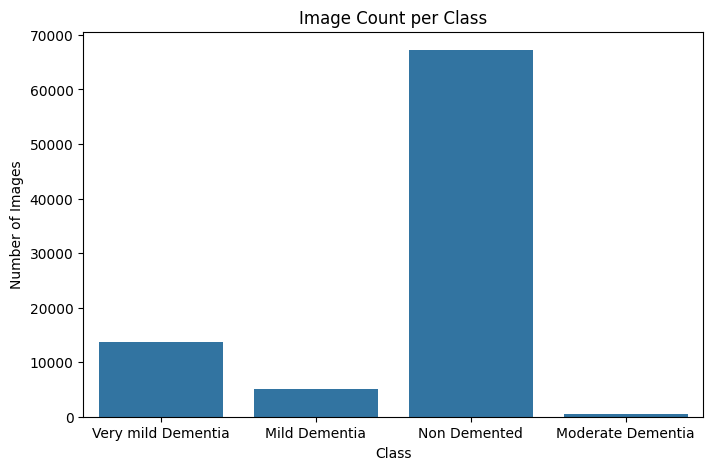

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Images height and width statistics

In [ ]:
heights = image_shapes[:, 0]
widths = image_shapes[:, 1]
channels = image_shapes[:, 2]

print(f"Image Height - Mean: {np.mean(heights):.1f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
print(f"Image Width  - Mean: {np.mean(widths):.1f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Channels: {np.unique(channels)}")

Image Height - Mean: 248.0, Min: 248, Max: 248
Image Width  - Mean: 496.0, Min: 496, Max: 496
Channels: [3]


# Display a sample image for each class

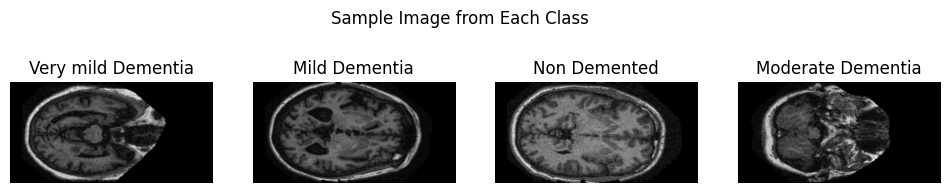

In [ ]:
plt.figure(figsize=(12, 6))
for i, cls in enumerate(class_names):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = Image.open(img_path)
    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Image from Each Class",  y=0.7)
plt.show()


# Pixels values distribution

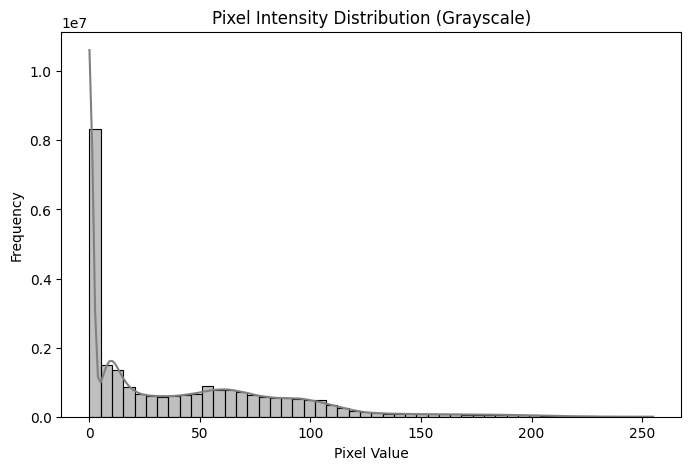

In [ ]:
pixel_values = []

for cls in class_names:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path)[:50]:  # sample of 50 images per class
        try:
            img = Image.open(os.path.join(class_path, file)).convert('L')  # Converting to grayscale
            pixel_values.extend(np.array(img).flatten())
        except:
            continue

plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, kde=True, color='gray')
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


# Checking for duplicate and corrupted images

In [ ]:
from hashlib import md5

hashes = set()
duplicates = []
corrupted = []

for cls in class_names:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path):
        img_path = os.path.join(class_path, file)
        try:
            with open(img_path, 'rb') as f:
                file_hash = md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicates.append(img_path)
            else:
                hashes.add(file_hash)
        except:
            corrupted.append(img_path)

print(f"Found {len(duplicates)} duplicate images")
print(f"Found {len(corrupted)} corrupted images")


Found 0 duplicate images
Found 0 corrupted images


# Necessary imports for data preprocessig and implementing deep learning models

In [3]:
import zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from glob import glob

# Dividing the data into two new folders: train and test and balancing classes

In [4]:
import os
import shutil
import numpy as np

# Define paths for each class
path_1 = '/content/Data/Mild Dementia'
path_2 = '/content/Data/Moderate Dementia'
path_3 = '/content/Data/Non Demented'
path_4 = '/content/Data/Very mild Dementia'

# Root directory for train and test split
rootdir = '/content/Data'
train_dir = os.path.join(rootdir, 'train')
test_dir = os.path.join(rootdir, 'test')

np.random.seed(42)

classes = {
    '1': 'Mild Dementia',
    '2': 'Moderate Dementia',
    '3': 'Non Demented',
    '4': 'Very mild Dementia'
}

for class_name in classes.values():
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

def split_and_copy_limited(source_path, class_name, train_dest, test_dest, total_limit=488, test_ratio=0.2):
    all_files = os.listdir(source_path)
    all_files = [f for f in all_files if os.path.isfile(os.path.join(source_path, f))]
    np.random.shuffle(all_files)


    limited_files = all_files[:total_limit]


    split_index = int(len(limited_files) * (1 - test_ratio))
    train_files = limited_files[:split_index]
    test_files = limited_files[split_index:]


    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))


    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

# Apply the function to all classes
split_and_copy_limited(path_1, 'Mild Dementia', train_dir, test_dir)
split_and_copy_limited(path_2, 'Moderate Dementia', train_dir, test_dir)
split_and_copy_limited(path_3, 'Non Demented', train_dir, test_dir)
split_and_copy_limited(path_4, 'Very mild Dementia', train_dir, test_dir)

print("Balanced train-test split (488 images per class) completed successfully!")


Balanced train-test split (488 images per class) completed successfully!


In [5]:
train_path = '/content/Data/train'
test_path = '/content/Data/test'

# Data preprocessing(Pixels normalization, images resizing, data augmentation)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1560 images belonging to 4 classes.
Found 392 images belonging to 4 classes.


# Visualizig images after data preprocessing (data augmentation)

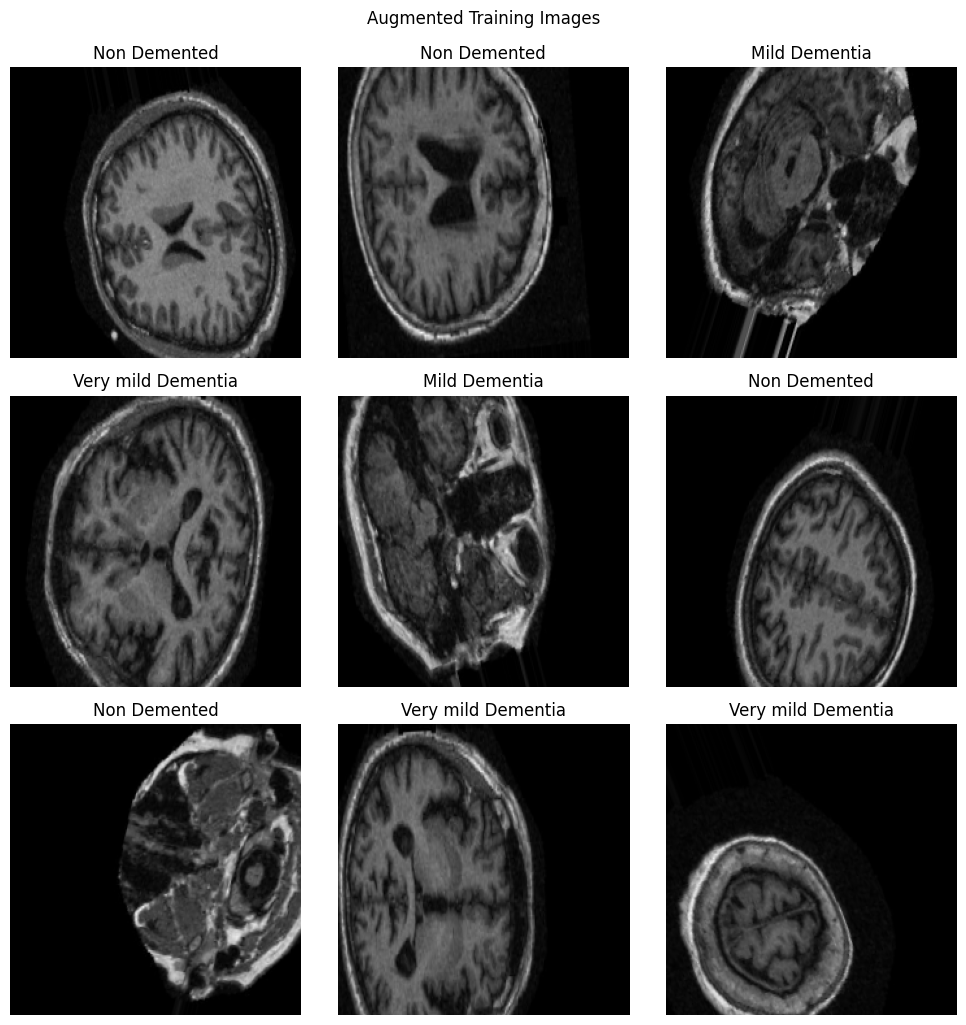

In [ ]:
images, labels = next(train_generator)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Images", y=1.02)
plt.show()


# Train and test images statistics

In [ ]:
print("Class indices:", train_generator.class_indices)

print("\nTrain set class distribution:")
for class_name, count in zip(train_generator.class_indices.keys(), train_generator.classes):
    print(f"{class_name}: {(train_generator.classes == train_generator.class_indices[class_name]).sum()}")

print("\nTest set class distribution:")
for class_name in test_generator.class_indices.keys():
    print(f"{class_name}: {(test_generator.classes == test_generator.class_indices[class_name]).sum()}")


Class indices: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}

Train set class distribution:
Mild Dementia: 390
Moderate Dementia: 390
Non Demented: 390
Very mild Dementia: 390

Test set class distribution:
Mild Dementia: 98
Moderate Dementia: 98
Non Demented: 98
Very mild Dementia: 98


<ipython-input-16-3ac07acede3d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_df, palette="pastel")


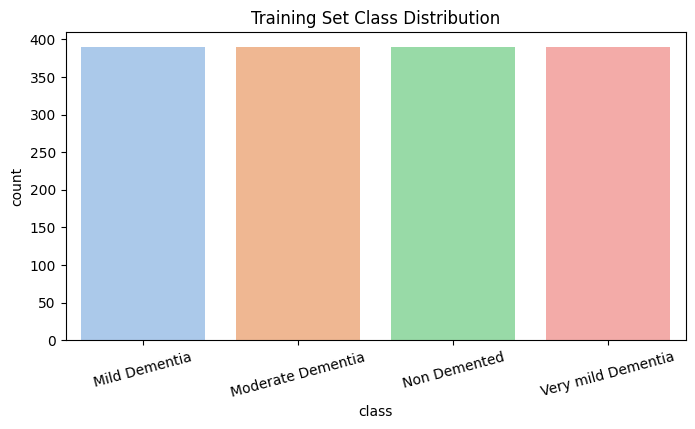

In [ ]:
import pandas as pd

# For training set
train_labels = [idx_to_class[c] for c in train_generator.classes]
train_df = pd.DataFrame(train_labels, columns=['class'])

plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=train_df, palette="pastel")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

<ipython-input-17-a3178d7b8d82>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_df, palette="pastel")


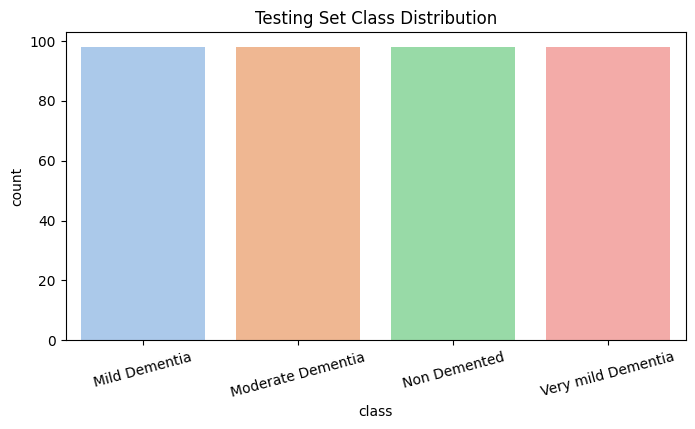

In [ ]:
# For testing set
test_labels = [idx_to_class[c] for c in test_generator.classes]
train_df = pd.DataFrame(test_labels, columns=['class'])

plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=train_df, palette="pastel")
plt.title("Testing Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

#Feature Extraction & Model implementation:

Using VGG16 as a feature extractor and classifying using 100 neurons and a softmax activation function as well as using RELU, ADAM optimizer, a regularization rate of 0.0006, and 10 epochs.

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to use as feature extractor (No fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add top layer of 100 neurons, relu, regularization rate of 0.0006, and softmax
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu', kernel_regularizer=l2(0.0006))(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base and top layers
model = Model(inputs=base_model.input, outputs=output)

# Compile model
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,223,992 (65.70 MB)

 Trainable params: 2,509,304 (9.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 834ms/step - accuracy: 0.2853 - loss: 2.5411 - val_accuracy: 0.4107 - val_loss: 1.4226
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 0.4214 - loss: 1.3905 - val_accuracy: 0.4745 - val_loss: 1.2315
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 0.4316 - loss: 1.3141 - val_accuracy: 0.5281 - val_loss: 1.1470
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 524ms/step - accuracy: 0.5017 - loss: 1.1865 - val_accuracy: 0.5255 - val_loss: 1.1434
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 528ms/step - accuracy: 0.5174 - loss: 1.1541 - val_accuracy: 0.5510 - val_loss: 1.0882
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 519ms/step - accuracy: 0.5347 - loss: 1.1189 - val_accuracy: 0.5842 - val_loss: 1.0557
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 525ms/step - accuracy: 0.5592 - loss: 1.0749 - val_accuracy: 0.4821 - val_loss: 1.1756
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 532ms/step - accuracy: 0.5875 - loss: 1.0627 - val_accu

In [10]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.6777 - loss: 0.9208
Test Accuracy: 66.07%


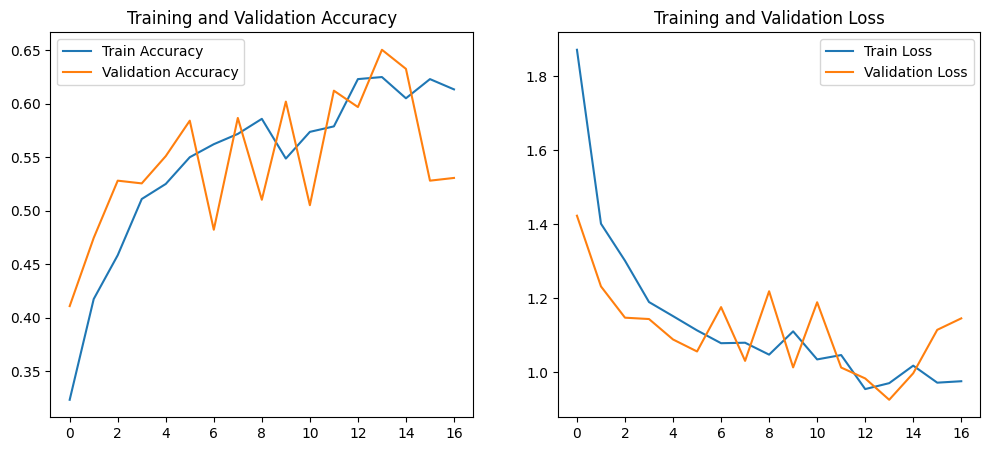

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step


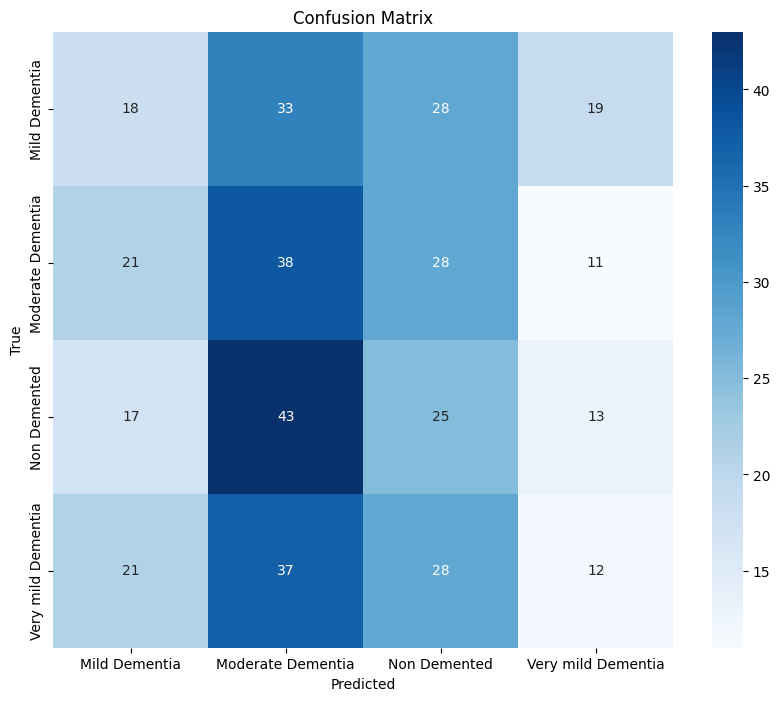

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=59265242fe9867e5c32313c984ce537752c5152b534d90950a429ac722172a5e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime import lime_image
import shap

# Grad-cam

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-15-2a749fa7488e>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


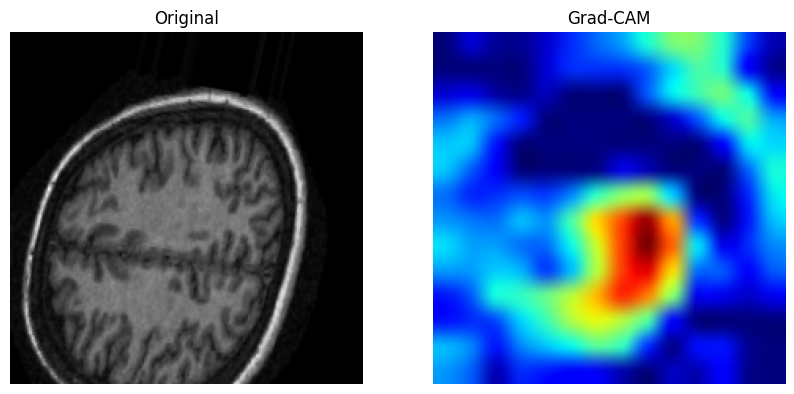

In [15]:
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

last_conv_layer_name = "block5_conv3"

test_images, test_labels = next(test_generator)

img = test_images[0]
img_array = np.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

display_gradcam(img, heatmap)

# Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/st

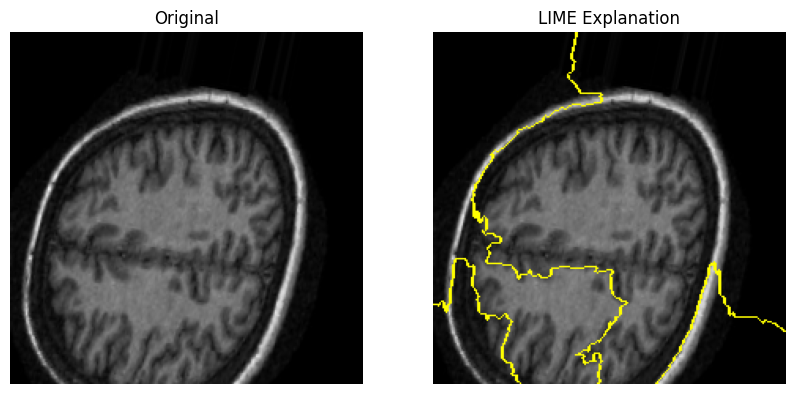

In [16]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def predict_fn(images):
    return model.predict(images)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    test_images[0].astype('double'),
    predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_images[0])
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

# SHAP

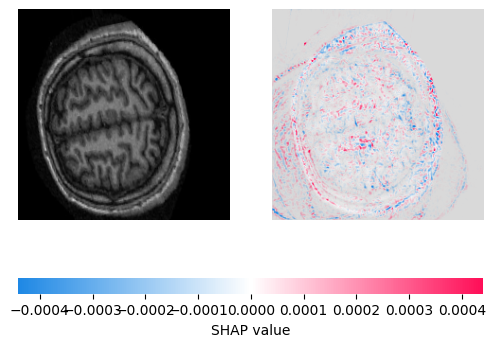

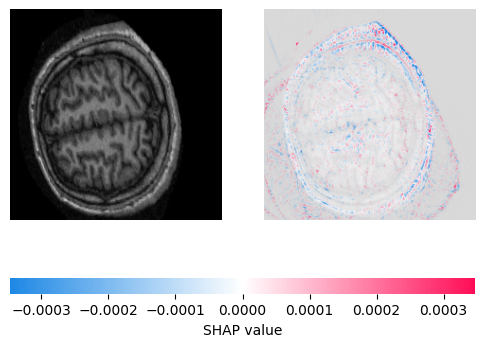

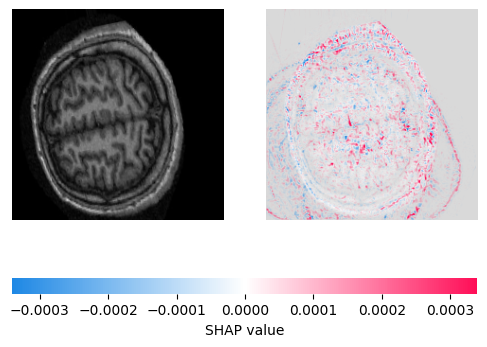

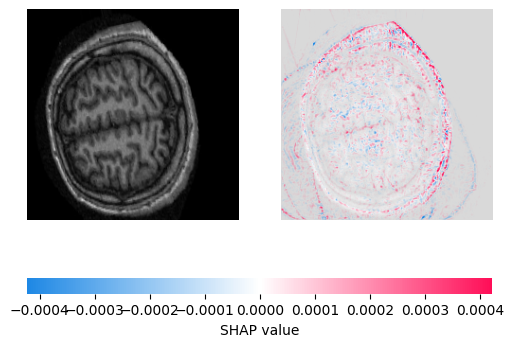

In [ ]:
import numpy as np
import shap
import tensorflow as tf

image_batch, label_batch = next(test_generator)
image_batch = image_batch[:10]

image_idx = np.random.randint(0, len(image_batch))
image_to_explain = image_batch[image_idx]

image_to_explain = tf.image.resize(image_to_explain, (224, 224))

explainer = shap.DeepExplainer(model, image_batch[:5])

image_to_explain_np = image_to_explain.numpy()
image_to_explain_reshaped = np.reshape(image_to_explain_np, (1, 224, 224, 3))

shap_values = explainer.shap_values(image_to_explain_reshaped)

if len(shap_values) > 0:
    for class_idx in range(shap_values[0].shape[-1]):

        shap.image_plot([shap_values[0][:, :, :, class_idx]], np.array(image_to_explain_np))
